# Importing Packages

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARMA
from scipy.stats.distributions import chi2
import seaborn as sns
sns.set()
import warnings
warnings.filterwarnings("ignore")

### statsmodels.tsa.stattools as sts 
Used to implement the Dickey-Fuller (DF) test

# Loading & Transforming the data

In [4]:
raw_csv_data = pd.read_csv("Index2018.csv")
df_comp = raw_csv_data.copy()
df_comp.date = pd.to_datetime(df_comp.date, dayfirst = True)
df_comp.set_index("date", inplace = True)
df_comp = df_comp.asfreq('b')
df_comp = df_comp.fillna(method = 'ffill')

# Removing Surplus Data

In [5]:
df_comp['market_value'] = df_comp.spx

In [6]:
del df_comp['spx'],df_comp['dax'],df_comp['ftse'],df_comp['nikkei']
size = int(len(df_comp)*0.8)
df, df_test = df_comp.iloc[:size], df_comp.iloc[size:]

# White Noise

A special type of time-series, where the data doesn't follow a pattern.

It can also be defined as a sequence of random data, where every value has a time-period associated with it.

##### NOTE - Since there is no pattern, we cannot predict white noise

#### Criteria for a time series to be considered white noise:
1. Constant mean (always zero)
2. Constant variance
3. No autocorrelation in any period -> No clear relationship betweeen past and present values i.e. autocorrelation = 0 (always).

<img src = "Images/white noise.png">

In [7]:
wn = np.random.normal(loc = df.market_value.mean(), scale = df.market_value.std(), size = len(df))

### random.normal() 
Part of the NumPy package which creates an array of random values from a normal distribution.

If we want the sequence to be comparable to the S&P one, we should set its mean and standard deviation.

For convenience, Pandas provides methods called mean() and std(), which estimate those values for an attribute of a data frame. 


### loc()
The location argument of the loc() method takes numbers for the average point of the distribution.

scale paramter -> indicates how wide the distribution is.

size parameter -> defines how many values we want to generate.

##### NOTE - If we want the sequence to serve as a good comparison, it should have as many elements as our time series.

In [8]:
df['wn'] = wn

In [9]:
df.describe()

,market_value,wn
count,5021.000000,5021.000000
mean,1091.651926,1088.698979
std,292.559287,288.723411
min,438.920000,21.272644
25%,914.620000,890.941147
50%,1144.650000,1089.497677
75%,1316.280729,1281.905023
max,1570.252238,2090.370630


##### NOTE - The mean of two columns is similar but not entirely equal. 

#### The reason is that the white noise values we generated are normally distributed around the mean of the S&P. However, since each one is generated individually, the average does not have to end up being the same.

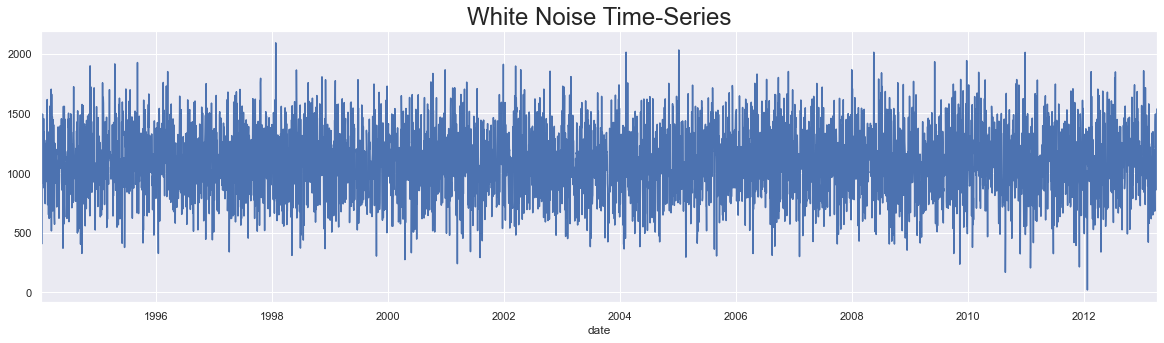

In [10]:
df.wn.plot(figsize = (20, 5))
plt.title("White Noise Time-Series", size = 24)
plt.show()

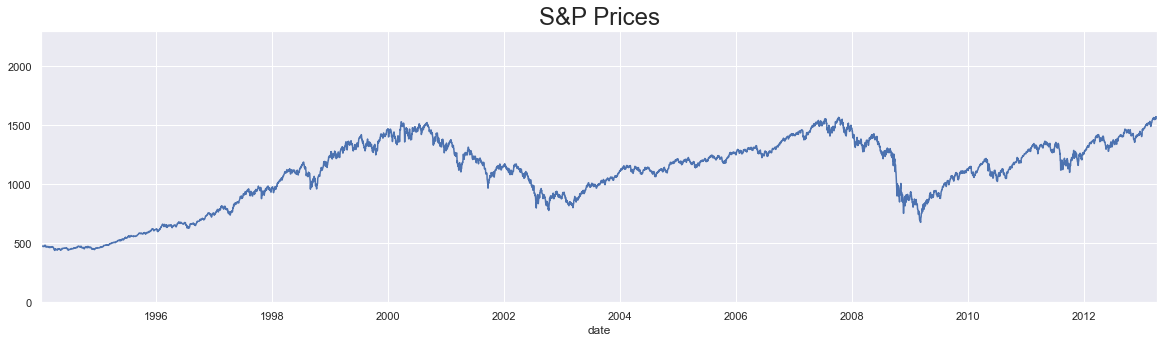

In [11]:
df.market_value.plot(figsize = (20,5))
plt.title("S&P Prices", size = 24)
plt.ylim(0,2300)
plt.show()

### ylim()
Used to reset the range of values on Y-axis.

# Random Walk
A special type of time-series, where values tend to persist over time and the differences between periods are simply white noise.

##### Suppose Pt = Prices and Et = Residuals
##### Random walk -> Pt = Pt-1 + Et
##### where Et -> white noise (arbitrary and cannot be predicted)

This suggests that the best estimates for prices today are prices yesterday.

In [12]:
rw = pd.read_csv("RandWalk.csv")
rw.date = pd.to_datetime(rw.date, dayfirst = True)
rw.set_index("date",inplace = True)
rw = rw.asfreq('b')

In [13]:
rw.describe()

,price
count,5021.000000
mean,1269.944293
std,444.216793
min,585.483034
25%,931.550429
50%,1156.363045
75%,1488.362029
max,2715.508720


In [14]:
df['rw'] = rw.price

In [15]:
df.head()

,market_value,wn,rw
date,,,
1994-01-07,469.90,1424.549022,1122.139662
1994-01-10,475.27,857.974112,1080.347860
1994-01-11,474.13,406.069868,1082.095245
1994-01-12,474.17,864.090640,1083.639265
1994-01-13,472.47,1207.201985,1067.146255


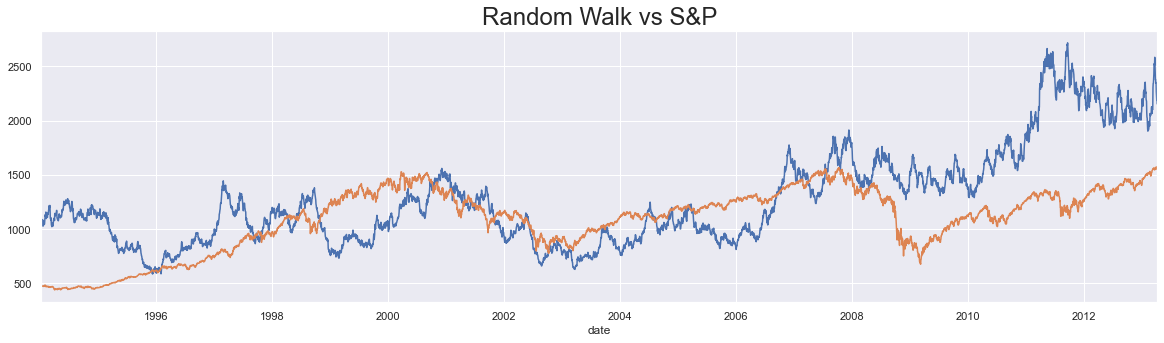

In [18]:
df.rw.plot(figsize = (20,5))
df.market_value.plot()
plt.title("Random Walk vs S&P", size = 24)
plt.show()

##### NOTE - Both graphs have the following similarities:
1. Small variations betweeen consecutive time periods.
2. Cyclical increases and decreases in the short periods of time.

#### Market Efficiency
Measures the level of difficulty in forecasting correct future values.

##### NOTE - 
1. If a time series resembles a random walk, the prices CAN'T be predicted with great efficiency.
2. If future prices can be predicted with great accuracy, then there are ARBITRAGE opportunities.

#### Arbitrage
When investors manage to buy and sell commodities and make a safe profit while the price adjusts.

According to theory, if such opportunities exist within a market, investors are bound to take advantage which would eventually lead to a price that matches the expected one. As a result, prices adjust accordingly.

### Stationarity
<img src = "Images/stationarity.png">

Implies that taking consecutive samples of data with the same size should have identical covariances regardless of the starting point.

This characteristic of the data is also known as - 
#### weak form stationarity or covariance stationarity.

##### NOTE - Covariance is a measure of how much two random variables vary together. It’s similar to variance, but where variance tells you how a single variable varies, co variance tells you how two variables vary together.

#### Assumptions for covariance stationarity:
1. Constant mean
2. Constant variance
3. Consistent covariance between periods at an identical distance from one another. In other words, we want to have the same covariance between the first and fourth period as we do for the third and sixth since they are three intervals apart.

##### NOTE  - An obvious example of a weak form stationarity is white noise.

Refer to criteria for a time series to be considered white noise above.

Since covariance is simply correlation multiplied by the standard deviations, it would also equal zero. 

Therefore, white noise really satisfies all the assumptions of a covariance stationarity process.

##### NOTE - Stationarity = Covariance stationarity (in real world scenarios)

### Determining Weak Form Stationarity

To conduct proper time series analysis, it is vital to determine whether the data follows stationarity or non-stationarity process.

### Dickey-Fuller (DF) Test

An augmented version of the test was developed for time dependency in the data.

##### Null Hypothesis             -> H0
##### Alternate Hypothesis -> H1

#### Important
The null hypothesis (H0) of the Dickey Fuller Test assumes NON-STATIONARITY. More precisely, it assumes that the one lag autocorrelation coefficient is lower than one.

The alternate hypothesis (H0) of the Dickey Fuller Test assumes STATIONARITY.

When we have computed the test statistic, we can compare it to the critical value in the Dickey-Fuller table.

#### If test statistic < critical value
#### => Reject the null hypothesis => Data comes from a stationary process

#### Dickey-Fuller (DF) Test - Hypothesis
<img src="Images/DF test.png">

In [38]:
sts.adfuller(df.market_value)

(-1.7369847452352478,
 0.41216456967706006,
 18,
 5002,
 {'1%': -3.431658008603046,
  '5%': -2.862117998412982,
  '10%': -2.567077669247375},
 39904.880607487445)

### adfuller()
Used to implement the Dickey-Fuller (DF) test.

##### NOTE - Python provides us with 1%, 5% and 10% critical values of the Dickey-Fuller (DF) test.

#### FIRST LINE -> we can notice that the t statistic value of -1.7369847452352478 is greater than each of the critical values. Thus, for all these levels of significance, we do not find sufficient evidence of stationarity in the data set.

#### SECOND LINE -> expresses the p value (0.41216456967706006) associated with the t statistic.

#### The p value suggests there is roughly a 40 percent chance of not rejecting the null hypothesis. So we can't confirm the data is stationarity.

### `p value (higher) -> process might be non-stationarity
### p value (lower) -> process might be stationarity.`

#### THIRD LINE -> number of lags used in the regression when determining the t statistic. In this case we have 18, so there are some autocorrelation going back 18 periods. We take this into account when picking up the appropriate model.

#### FOURTH LINE -> number of observations used in the analysis. This value depends on the number of lags used in the regression. So the two should usually add up to the size of the data set.

#### LAST LINE -> estimates the `maximized information criteria` provided there is some apparent correlation.
##### `The lower the information criteria value, the easier it is to make predictions for the future.`

##### NOTE - A dependent variabxle that is LAGGED in time. For example, if Yt is the dependent variable, then Yt-1 will be a lagged dependent variable with a lag of ONE PERIOD. Lagged values are used in Dynamic Regression modeling.

sts.adfuller(df.wn)

##### NOTE - We know that white noise is a stationarity process so we expect to get a very low p value. Additionally, since there is no autocorrelation in white noise, there should be no lags involved in the regression.

In [40]:
sts.adfuller(df.rw)

(-1.3286073927689719,
 0.6159849181617385,
 24,
 4996,
 {'1%': -3.4316595802782865,
  '5%': -2.8621186927706463,
  '10%': -2.567078038881065},
 46299.333497595144)

##### NOTE - We don't have significant evidence to identify this time series as stationarity. Based on the p value, there is more than 60% chance the data comes from a non stationarity process.

#### More often than not, random walk intervals of the same size differ significantly due to uncertainty of the process. So each day's price might go up or down, but the starting position is always different. Moreover, chance dictates that we can have intervals of alternating ups and downs and prices as well as once with constant increase.


###  Intervals of Alternating Ups and Downs and Prices
<img src = "Images/up-down.png">

###  Constant Increase
<img src = "Images/constant.png">

### Conclusion
<img src = "Images/conclusion.png">

## Seasonality

Trends will appear on a cyclical basis.

### Decomposition
Split into 3 effects:
1. Trend - Pattern consistent throughout the data.
2. Seasonal - Cyclical effects due to seasonality
3. Residual - Error of prediction or the difference between the actual data and the model we fit.

### Type of Decompositon
1. "Naive" Decomposition - We expect a linear relationship between the three parts and the observed time series.

Two main approaches of "Naive" Decomposition:
1. Additive - Assumes that for any time period, the observed value is the sum of the trend, seasonal and residual. 

#### Observed value = Trend + Seasonal + Residual

2. Multiplicative - Assumes the original series is a product of the trend, seasonal and residual.

#### Observed value = Trend * Seasonal * Residual

##### statsmodels.tsa.seasonal package of the statsmodel takes a time series and splits it up into three parts.

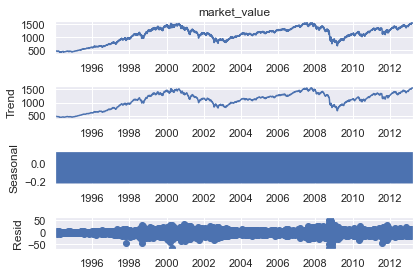

In [42]:
s_dec_additive = seasonal_decompose(df.market_value, model = "additive")
s_dec_additive.plot()
plt.show()

##### NOTE - As we can see, the trend closely resembles the observed series. That's because the decomposition function uses the previous values as a trend-setter.

##### The SEASONAL plot looks like a rectangle. This happens when the values are CONSTANTLY OSCILLATING back and forth and the figure size is too small. In our case, the linear change results from constantly switching up and down between -0.2 and +1 every period. Therefore, there is no concrete cyclical pattern determined by using "Naive" decomposition.

##### The RESIDUAL plot is the errors of our model estimates. They are the difference between the TRUE VALUES and PREDICTIONS for  ANY PERIOD. As we can see, the residuals vary greatly around the turn of the century and around 2008, this can be explained by the instability caused by the dotcom and housing prices bubbles respectively.

#### Overall, the results of the additive decomposition suggest no seasonality in the data.

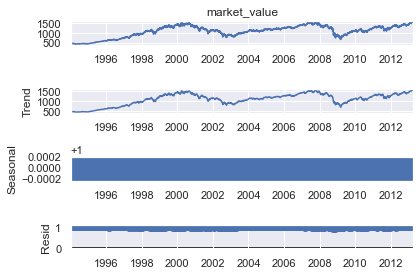

In [43]:
s_dec_multiplicative = seasonal_decompose(df.market_value, model = "multiplicative")
s_dec_multiplicative.plot()
plt.show()

#### This proves that there is no seasonality among S&P prices.

### Correlation between Past and Present Values
1. Correlation - Measures the similarity in the change of values of two series.
2. Autocorrelation - Correlation between a sequence and itself. More precisely, it measures the level of resemblance between a sequence from several periods ago and the actual data. Such a series is called Lagged because it is essentially a delayed version of the original one.

### The Autocorrelation Function (ACF)
<img src = "Images/ACF1.png">

The ACF computes the autocorrelation value for however many lags we are interested in simultaneously.

Because the correlation of the time series observations is calculated with values of the same series at previous times, this is called a serial correlation, or an autocorrelation. A plot of the autocorrelation of a time series by lag is called the AutoCorrelation Function.

#### We need to assign a value to the lags argument because the default value is the length of the time series. In a set with thousands of observations, computing so many lag values would be extremely time consuming and unncessary.

##### NOTE - In time series analysis, common practices dictates analyzing the first 40 lags.

##### Keep in mind that by saying the first 40 lags, we mean the LAST 40 periods before the current one.

#### zero -> This argument indicates whether we include current period values in the graph. 

##### For correlation functions, this is unnecessary because the correlation between a value and itself will always be one. This will lead to always having the first bar of the graph equal to one, which makes the plot more difficult to comprehend correctly. Therefore, setting the argument equal to false ensures we only observe a plot for higher lag values.

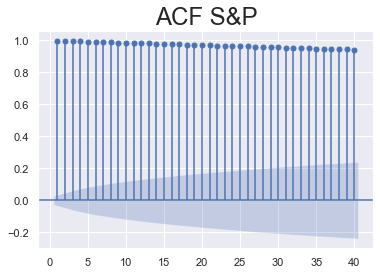

In [51]:
sgt.plot_acf(df.market_value, lags = 40, zero = False)
plt.title("ACF S&P", size = 24)
plt.show()

#### X-axis -> Lags
#### Y-axis -> Possible values for the autocorrelation coefficient.

##### NOTE - Correlation can only take values between -1 and +1.

##### The THIN LINE across the plot represents the autocorrelation between the TIME SERIES and a LAGGED COPY OF ITSELF.

##### The FIRST LINE indicates autocorrelation one time period ago.

#### BLUE AREA AROUND X-AXIS -> NOT SIGNIFICANT. 
The values situated outside are significantly different from zero which suggests the existence of autocorrelation for that specific lag.

<img src = "Images/ACF.png">

##### NOTE - For instance, today's prices are usually closer to yesterday's prices than the prices a month ago.

#### Notice how all the lines are higher than the blue region, this suggests the coefficients are significant which is an indicator of time dependance in the data. Moreover, we can see that autocorrelation barely diminishes as the lags increase.

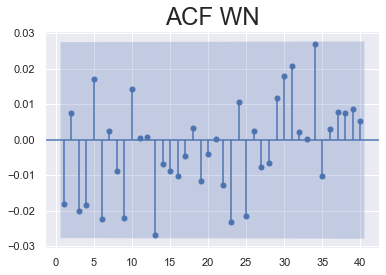

In [53]:
sgt.plot_acf(df.wn, lags = 40, zero = False)
plt.title("ACF WN", size = 24)
plt.show()

##### NOTE - We have values going either way, so there are patterns of positive and negative autocorrelation. This contrasts the ACF S&P where all values were positive. Also, observe how all the lines fall within the blue area, thus the coefficients are NOT SIGNIFICANT ACROSS THE ENTIRE PLOT. This suggests there is NO AUTOCORRELATION for an lag which is one of the assumptions of white noise.

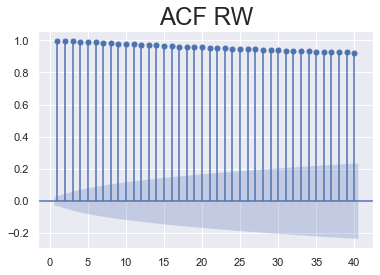

In [55]:
sgt.plot_acf(df.rw, lags = 40, zero = False)
plt.title("ACF RW", size = 24)
plt.show()

### Partial Autocorrelation Function (PACF)
<img src = "Images/PACF1.png">

Autocorrelation measures the similarity between a time series and a lagged version of itself. However, the coefficients also capture second hand effects.

For instance, examine the value of the autocorrelation coefficient for the third lag. It captures `direct` and `indirect` ways in which the lagged series affects the original one.

By `indirect`, we refer to all the other channels through which past data affects current data.

If we wish to determine only the `direct` relationship between the TIME series and its lagged version, we need to compute the `partial autocorrelation`

To do this, we can use a function like the PACF called the partial autocorrelation function

`Definition` - A partial autocorrelation is a summary of the relationship between an observation in a time series with observations at prior time steps with the relationships of intervening observations removed.

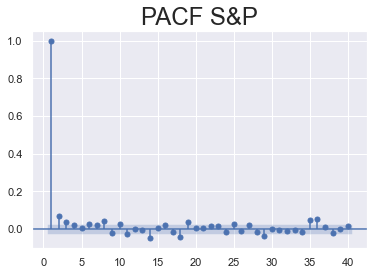

In [59]:
sgt.plot_pacf(df.market_value, lags = 40, zero = False, method = 'ols')
plt.title("PACF S&P", size = 24)
plt.show()

A tremendous contrast to the ACF plot, where all values up to 40 lag's were significant.

Also, some of the values like the ninth lag are negative, this means that higher values nine periods ago result in lower values today and vice versa.

The difference between the two graphs comes from the way the PACF works. It cancels out all additional channels in which a previous period value affects the present one.

For instance, the PACF measures the effect values in period t-2 to have on values in period T directly.

Compared to the values from the ACF function, the PACF ones cancel out the effects prices two days ago have on prices yesterday, which in turn affect prices today.

Therefore, the ACF shows the combined effect of the prices from two days ago, both direct and through yesterday's prices, while the PACF only shows the direct effect.

However, we must note that ACF and PACF values for the first lag should be `identical`.

This is because there are `no other channels` through which passed values can affect present values.

##### NOTE - how most values after the third lag are within the blue area. This means they `aren't significantly different from zero`. So the numeric values attached to them are not important. Since we can assume they're all essentially zero, being positive or negative is somewhat random without any lasting effects.

<img src = "Images/PACF.png">

### PACF for White Noise
By definition, there should be `no autocorrelation` between the elements of a white noise sequence, thus we expect the values for all periods to be insignificant.

##### NOTE - most of the values aren't significantly different from zero. Some of the coefficients can end up outside the blue area and seem significant, but that is completely random.

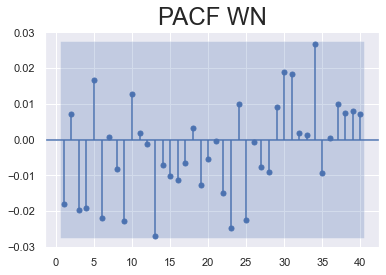

In [61]:
sgt.plot_pacf(df.wn, lags = 40, zero = False, method = 'ols')
plt.title("PACF WN", size = 24)
plt.show()

### PACF for Random Walk

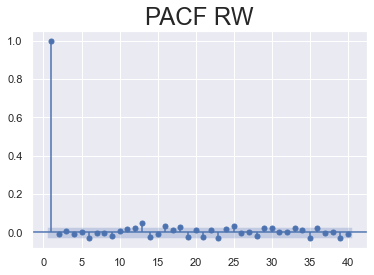

In [62]:
sgt.plot_pacf(df.rw, lags = 40, zero = False, method = 'ols')
plt.title("PACF RW", size = 24)
plt.show()

### PACF vs ACF
In ACF, we care about both the `direct` and `indirect` relationship whereas in PACF, we only care about the `direct` relationship (Remember Salmon example from the YouTube video).

ACF tells us about the prices a number of periods ago (indirect) and the price of the product today (direct).

If we want to see if the price of the product a number of periods ago is a `good predictor` of the price of the product today, then we use `PACF`. Based on ACF, it might seem like it's a good predictor because the correlation would be high but that correlation might only be high because of the `indirect` effect. It might be that the `direct` effect has `little to no correlation` and therefore, it will barely help us at all with predicting the prices.

`
ACF -> Direct + Indirect effects (through the intermediary time periods)
PACF -> Only Direct effects`

##### NOTE - PACF plot can be negative since the price of product a number of periods ago negatively impacts the price of the product today.

#### PACF tells us the coefficient of the price of the product that many periods ago on the price of the product today and if that coefficient if different from zero (statistically zero - being inside error bands) then it's a good factor into a model because it can help us make that prediction.

#### PACF plot helps us identify a good time series model to predict the price of the product today based on the price of the product some number of periods ago.

#### The ACF and PACF will tell us how many periods (lags) we should consider for forecasting.

<img src = "Images/acf-pacf.png">

### Picking Up the Correct Model
1. We start with a simple model and expand it as long as it follows several conditions. For starters, the `new coefficients` for the more complex model need to be `significantly different from zero`. If that `does not hold true`, the estimates for these parameters are `essentially zero`. Therefore, they `don't help us estimate future values`. This means they hold `no predictive powers`, so we must admit them and `revert back to the simpler model`.
2. Secondly, we want our model to be `parsimonious` or in other words, `as simple as possible`. Generally, we prefer using a `simpler model to a more complicated one`, unless the latter provides significantly better predictions. 

#### Generally:
#### Simpler model > Complex model

#### Significantly better predictions:
#### Simpler model < Complex model

3. To determine whether the predictions are significantly better, we introduce a statistical test called the `Log-Likelihood Ratio Test`. However, the test can `only` be applied to models with `different degrees of freedom`. Thus, when comparing several models with the `same total number of required lags`, we need to compare the `information criteria` of each one. The `lower the coefficient, the less data the model requires to make accurate predictions`. 
4. The two most prominent measurements of the kind are the `AIC` and `BIC`. Since we prefer simplicity, we opt for the model with `lower AIC and BIC coefficients`.
5. If our model fits well, there should be `no trend we have failed to account for`, therefore, the `residuals` for the model should `resemble white noise` so we can conclude there is `no other pattern we can account for without overtraining`.

##### NOTE - By overtraining, we mean that our model describes the given data too well and might perform underwhelmingly against a different data set.

#### Degrees of Freedom -> Different -> Log-Likelihood Test
#### Degrees of Freedom -> Same -> Information Criteria
If we are comparing two models and we want to choose the better fit, then we choose the one with `Higher Log-Likelihood and Lower Information Criteria`.

##### NOTE - All the models can only be applied to stationary series. If the series is not stationary then we need to make it stationary.

<img src = "Images/st.png">

## Univariate Time Series
Time series that consists of `single observations` recorded over regular time intervals. Example - Monthly return data of a stock.

<img src = "Images/Information Criteria.png">

### AutoRegressive (AR) Model 
<img src = "Images/AR.png">

Relies on past period values and past periods only to predict current period values.

It's a `linear model` where:

#### Current Period Values = `Sum of past outcomes * numeric factor`.

<img src = "Images/AR1.png">

### Et -> Residual - The difference between our prediction for period "t" and the correct value.

#### AR(p) where p is parameter.
##### NOTE -
##### If B1, B2,.... = 0 then `Yt = B0 + Et` and it would become an `AR(0)` model.
##### If B2, B3,.... = 0 then `Yt = B0 + B1*Yt-1 + Et` and it would become an `AR(1)` model.
##### If B3, B4,.... = 0 then `Yt = B0 + B1*Yt-1 + B2*Yt-2 + Et` and it would become an `AR(2)` model.

### Examining ACF and PACF of Prices

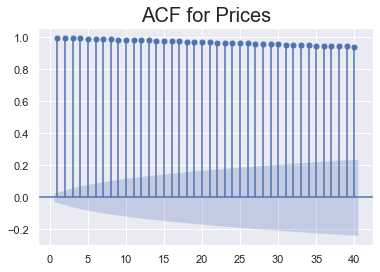

In [63]:
sgt.plot_acf(df.market_value, zero = False, lags = 40)
plt.title("ACF for Prices", size = 20)
plt.show()

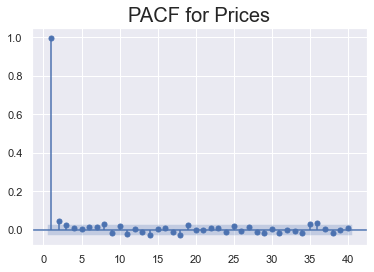

In [75]:
sgt.plot_pacf(df.market_value, alpha = 0.05, zero = False, lags = 40)
plt.title("PACF for Prices", size = 20)
plt.show()

#### NOTE - 
1. Coefficients from the 25th lag onwards are not significant, so we can just ignore them. To elaborate, since the coefficients will be extremely close to zero, we assume their impact on the model is minimal, so they're not relevant to us. Thus our model must include less than 25 lags.
2. Values after the 22nd lag are negative. Since the frequency of the data is in business days and there are roughly 22 business days in a month, we can anticipate some cyclical changes every month. In other words, the values a month ago negatively affect the values today. In reality, we can see that these changes are vastly overshadowed by the ones occurring in later periods when it comes to impact, so we should not overanalyze their contribution.

In [251]:
raw_csv_data = pd.read_csv("Index2018.csv")
df_comp = raw_csv_data.copy()
df_comp.date = pd.to_datetime(df_comp.date, dayfirst = True)
df_comp.set_index("date", inplace = True)
df_comp = df_comp.asfreq('b')
df_comp = df_comp.fillna(method = 'ffill')

In [252]:
df_comp['market_value'] = df_comp.ftse

In [253]:
del df_comp['spx'],df_comp['dax'],df_comp['ftse'],df_comp['nikkei']
size = int(len(df_comp)*0.8)
df, df_test = df_comp.iloc[:size], df_comp.iloc[size:]

### Fitting AR(1) Model for Index Prices

#### ARMA(x, order = (a,b))
#### where
##### x -> Time Series we want to model
##### order -> Defines the specific model we want to use
##### a -> Number of past values we wish to incorporate into the model
##### b = 0 -> Not taking any of the residual values into consideration
##### order(1,0) -> `Simple AR(1) Model`

After defining the model, we need to see how it fits the data and what values it assigns to the constant C and the coefficient PHI of the AR equation. To do so, we use `fit()`

Furthermore, we can create a summary of the results using `summary()`

In [256]:
model_ar = ARMA(df.market_value, order = (1,0))
results_ar = model_ar.fit()
results_ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5021
Model:                     ARMA(1, 0)   Log Likelihood              -27622.600
Method:                       css-mle   S.D. of innovations             59.258
Date:                Fri, 14 Jan 2022   AIC                          55251.201
Time:                        19:45:33   BIC                          55270.765
Sample:                    01-07-1994   HQIC                         55258.056
                         - 04-05-2013                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               5003.9154    488.238     10.249      0.000    4046.987    5960.844
ar.L1.market_value     0.9985      0.001   1294.486      0.000       0.997       1.000
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0015           +0.0000j            1.0015            0.0000
-----------------------------------------------------------------------------
"""

#### 1061.0287 -> Constant C value
#### 0.9994 -> PHI 1 => This suggests that this is the coefficientfor the AR value from one lag ago for the associated time series.

#### `Standard Error (std err)` column -> It's a measure of how far away, on average, the model's predictions are from the true values.

#### `Z` column -> The associated test statistics for significance with the P values on its right. Since `P = zero` for both, we can safely conclude that the `constant and the one lag value are both significantly different from zero`.

#### The last two columns represent the critical values for the 95 percent confidence interval. if zero is not a part of it, we can confirm the coefficients are significant.

##### NOTE - Since both coefficients are significantly different from zero, we can try fitting a more complex model for greater accuracy.

#### Why does the model estimate two values, when we're only using an AR(1) model?
The model always assumes there might be a constant in the model (even if it turns out to be non-significant).

In [257]:
model_ar_2 = ARMA(df.market_value, order = (2,0))
#results_ar_2 = model_ar_2.fit()
results_ar_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5021
Model:                     ARMA(2, 0)   Log Likelihood              -20085.280
Method:                       css-mle   S.D. of innovations             13.206
Date:                Fri, 14 Jan 2022   AIC                          40178.560
Time:                        19:45:36   BIC                          40204.646
Sample:                    01-07-1994   HQIC                         40187.701
                         - 04-05-2013                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               1049.2930    250.356      4.191      0.000     558.604    1539.982
ar.L1.market_value     0.9300      0.014     68.036      0.000       0.903       0.957
ar.L2.market_value     0.0694      0.014      5.074      0.000       0.043       0.096
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0005           +0.0000j            1.0005            0.0000
AR.2          -14.4037           +0.0000j           14.4037            0.5000
-----------------------------------------------------------------------------
"""

##### NOTE - The coefficients for PHI-1 and the constant have changed. That's because some of the changes in prices can be justified by the prices two days ago.

In [258]:
model_ar_3 = ARMA(df.market_value, order = (3,0))
#results_ar_3 = model_ar_3.fit()
results_ar_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5021
Model:                     ARMA(3, 0)   Log Likelihood              -20082.347
Method:                       css-mle   S.D. of innovations             13.198
Date:                Fri, 14 Jan 2022   AIC                          40174.694
Time:                        19:45:40   BIC                          40207.301
Sample:                    01-07-1994   HQIC                         40186.120
                         - 04-05-2013                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               1056.7902    259.087      4.079      0.000     548.989    1564.592
ar.L1.market_value     0.9277      0.014     68.256      0.000       0.901       0.954
ar.L2.market_value     0.0376      0.019      1.989      0.047       0.001       0.075
ar.L3.market_value     0.0342      0.014      2.423      0.015       0.007       0.062
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0005           -0.0000j            1.0005           -0.0000
AR.2           -1.0506           -5.3049j            5.4080           -0.2811
AR.3           -1.0506           +5.3049j            5.4080            0.2811
-----------------------------------------------------------------------------
"""

In [259]:
model_ar_4 = ARMA(df.market_value, order = (4,0))
#results_ar_4 = model_ar_4.fit()
results_ar_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5021
Model:                     ARMA(4, 0)   Log Likelihood              -20081.256
Method:                       css-mle   S.D. of innovations             13.195
Date:                Fri, 14 Jan 2022   AIC                          40174.511
Time:                        19:45:42   BIC                          40213.640
Sample:                    01-07-1994   HQIC                         40188.222
                         - 04-05-2013                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               1058.3153    265.349      3.988      0.000     538.240    1578.390
ar.L1.market_value     0.9269      0.014     68.578      0.000       0.900       0.953
ar.L2.market_value     0.0368      0.019      1.952      0.051      -0.000       0.074
ar.L3.market_value     0.0148      0.019      0.771      0.441      -0.023       0.053
ar.L4.market_value     0.0209      0.014      1.478      0.139      -0.007       0.049
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0005           -0.0000j            1.0005           -0.0000
AR.2           -3.9300           -0.0000j            3.9300           -0.5000
AR.3            1.1089           -3.3115j            3.4923           -0.1986
AR.4            1.1089           +3.3115j            3.4923            0.1986
-----------------------------------------------------------------------------
"""

#### If P > 0.05, we can reject the null hypothesis (We are using 5% significance level).
##### This suggests that the coefficient for the second lag isn't significantly different from zero. Therefore, we assume it's equal to zero.

#### This means that the prices two days ago do not severely affect those of today. A possible explanation is that all the effects they have are captured in yesterday's price, thus adding additional information doesn't provide significant value.

### We prefer models with `Higher Log-Likelihood` and `Lower Information Criteria`.

### We use the `Log-Likelihood Ratio(LLR) test ` to check if the models are significantly different from one another.

## LLR Test

#### mod_1 & mod_2 -> Models we want to compare
#### DF -> Degrees of Freedom

##### NOTE - We usually only compare models with a single difference in this department. So we're going to set the default value for D.F. = 1

#### `.llf` -> Extracts Log-Likelihood

##### NOTE - We imported "chi2" from the "scipy.stats.distributions" package.

#### After computing, this will rely on the Chi squared method and pass the L.R. and degrees of freedom as parameters. The value we store from calling said method will be the p value we want to define. 

#### Since we want to have a nice numeric representation of the P value, we're going to round the result to three decimal places. We do so by calling the round method when storing the variable. 

In [260]:
def LLR_test(mod_1, mod_2, DF = 1):
    L1 = mod_1.fit().llf
    L2 = mod_2.fit().llf
    LR = (2*(L2-L1))
    p = chi2.sf(LR, DF).round(3)
    return p

## Comparing Higher-Lag AR Models

In [261]:
model_ar_3 = ARMA(df.market_value, order = (3,0))
results_ar_3 = model_ar_3.fit()
print(results_ar_3.summary())
print("\nLLR test p-value = " + str(LLR_test(model_ar_2, model_ar_3)))

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.50009D+00    |proj g|=  1.91047D-04

At iterate    5    f=  5.50007D+00    |proj g|=  4.44089D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      8     14      1     0     0   0.000D+00   5.500D+00
  F =   5.5000739054137551     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                              ARMA Model Results                              
Dep. Variable:           market_value   No. Observati

 This problem is unconstrained.



At iterate   15    f=  5.50130D+00    |proj g|=  1.99325D-03

At iterate   20    f=  5.50127D+00    |proj g|=  3.00382D-04

At iterate   25    f=  5.50127D+00    |proj g|=  7.99361D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     25     46      1     0     0   7.994D-07   5.501D+00
  F =   5.5012677996708259     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.50009D+00    |proj g|=  1.91047D-04

At iter

 This problem is unconstrained.


In [262]:
model_ar_4 = ARMA(df.market_value, order = (4,0))
results_ar_4 = model_ar_4.fit()
print(results_ar_4.summary())
print("\nLLR test p-value = " + str(LLR_test(model_ar_3, model_ar_4)))

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.49745D+00    |proj g|=  2.04547D-04

At iterate    5    f=  5.49742D+00    |proj g|=  5.41789D-06

At iterate   10    f=  5.49742D+00    |proj g|=  1.77636D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     19      1     0     0   1.776D-07   5.497D+00
  F =   5.4974238387436216     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


                              ARMA Model Results                              
Dep. Variable:           market_value   No. Observations:                 5021
Model:                     ARMA(4, 0)   Log Likelihood              -27602.565
Method:                       css-mle   S.D. of innovations             59.022
Date:                Fri, 14 Jan 2022   AIC                          55217.130
Time:                        19:45:53   BIC                          55256.258
Sample:                    01-07-1994   HQIC                         55230.841
                         - 04-05-2013                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               5089.6412    559.945      9.090      0.000    3992.170    6187.113
ar.L1.market_value     0.9770      0.014     69.492      0.000       0.949       1.005
ar.L2.market_value  

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.49745D+00    |proj g|=  2.04547D-04

At iterate    5    f=  5.49742D+00    |proj g|=  5.41789D-06

At iterate   10    f=  5.49742D+00    |proj g|=  1.77636D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     19      1     0     0   1.776D-07   5.497D+00
  F =   5.4974238387436216     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

LLR test p-value = 0.0


### After calling the LLR. test, we see that the `difference in log likelihood is significant`. This suggests we should `opt for the more complicated model`. Similarly, we get a significant difference in the log likelihoods, if we run the test for the AR(3) and AR(4) models.

### We can repeat the same process of fitting a more complicated model and checking if it gives us `distinguishable greater log likelihoods until we reach a model where it doesn't.`

### Moreover, the said model should also have its `last lag not be significantly different from zero.`

### If we wish to examine the results of the model and the P-value simultaneously, we must use the `print function.`

In [263]:
model_ar_5 = ARMA(df.market_value, order = (5,0))
results_ar_5 = model_ar_5.fit()
print(results_ar_5.summary())
print("\nLLR test p-value = " + str(LLR_test(model_ar_4, model_ar_5)))

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.49700D+00    |proj g|=  2.06857D-04

At iterate    5    f=  5.49698D+00    |proj g|=  9.48575D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      8     13      1     0     0   1.776D-07   5.497D+00
  F =   5.4969823401944318     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


                              ARMA Model Results                              
Dep. Variable:           market_value   No. Observations:                 5021
Model:                     ARMA(5, 0)   Log Likelihood              -27600.348
Method:                       css-mle   S.D. of innovations             58.996
Date:                Fri, 14 Jan 2022   AIC                          55214.697
Time:                        19:45:56   BIC                          55260.346
Sample:                    01-07-1994   HQIC                         55230.693
                         - 04-05-2013                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               5089.6410    543.594      9.363      0.000    4024.217    6155.065
ar.L1.market_value     0.9791      0.014     69.481      0.000       0.952       1.007
ar.L2.market_value  

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.49700D+00    |proj g|=  2.06857D-04

At iterate    5    f=  5.49698D+00    |proj g|=  9.48575D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      8     13      1     0     0   1.776D-07   5.497D+00
  F =   5.4969823401944318     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

LLR test p-value = 0.035


In [218]:
model_ar_6 = ARMA(df.market_value, order = (6,0))
results_ar_6 = model_ar_6.fit()
print(results_ar_6.summary())
print("\nLLR test p-value = " + str(LLR_test(model_ar_5, model_ar_6)))

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.99959D+00    |proj g|=  9.63496D-04

At iterate    5    f=  3.99920D+00    |proj g|=  2.32525D-04

At iterate   10    f=  3.99920D+00    |proj g|=  1.59872D-06


 This problem is unconstrained.



At iterate   15    f=  3.99920D+00    |proj g|=  2.75335D-06

At iterate   20    f=  3.99920D+00    |proj g|=  1.59428D-05

At iterate   25    f=  3.99920D+00    |proj g|=  5.50671D-05

At iterate   30    f=  3.99920D+00    |proj g|=  5.40368D-04

At iterate   35    f=  3.99916D+00    |proj g|=  2.55898D-03

At iterate   40    f=  3.99913D+00    |proj g|=  1.21236D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     42     71      1     0     0   8.482D-06   3.999D+00
  F =   3.9991343046784631     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


                              ARMA Model Results                              
Dep. Variable:           market_value   No. Observations:                 5021
Model:                     ARMA(6, 0)   Log Likelihood              -20079.653
Method:                       css-mle   S.D. of innovations             13.191
Date:                Fri, 14 Jan 2022   AIC                          40175.307
Time:                        17:46:10   BIC                          40227.478
Sample:                    01-07-1994   HQIC                         40193.588
                         - 04-05-2013                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               1042.8538    277.426      3.759      0.000     499.108    1586.600
ar.L1.market_value     0.9267      0.013     69.325      0.000       0.900       0.953
ar.L2.market_value  

 This problem is unconstrained.



At iterate   10    f=  3.99950D+00    |proj g|=  3.55275D-07

At iterate   15    f=  3.99950D+00    |proj g|=  3.19744D-06

At iterate   20    f=  3.99950D+00    |proj g|=  1.68754D-06

At iterate   25    f=  3.99950D+00    |proj g|=  4.92939D-06

At iterate   30    f=  3.99950D+00    |proj g|=  3.90799D-05

At iterate   35    f=  3.99944D+00    |proj g|=  1.78697D-03

At iterate   40    f=  3.99943D+00    |proj g|=  1.35936D-04

At iterate   45    f=  3.99943D+00    |proj g|=  1.55431D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     46     71      1     0     0   1.510D-06   3.999D+00
  F =   3.99943378159

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.99959D+00    |proj g|=  9.63496D-04

At iterate    5    f=  3.99920D+00    |proj g|=  2.32525D-04

At iterate   10    f=  3.99920D+00    |proj g|=  1.59872D-06

At iterate   15    f=  3.99920D+00    |proj g|=  2.75335D-06

At iterate   20    f=  3.99920D+00    |proj g|=  1.59428D-05

At iterate   25    f=  3.99920D+00    |proj g|=  5.50671D-05

At iterate   30    f=  3.99920D+00    |proj g|=  5.40368D-04

At iterate   35    f=  3.99916D+00    |proj g|=  2.55898D-03

At iterate   40    f=  3.99913D+00    |proj g|=  1.21236D-05



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     42     71      1     0     0   8.482D-06   3.999D+00
  F =   3.9991343046784631     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

LLR test p-value = 0.083


In [264]:
model_ar_7 = ARMA(df.market_value, order = (7,0))
results_ar_7 = model_ar_7.fit()
print(results_ar_7.summary())
print("\nLLR test p-value = " + str(LLR_test(model_ar_6, model_ar_7)))

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.49532D+00    |proj g|=  2.03038D-04

At iterate    5    f=  5.49530D+00    |proj g|=  5.71099D-05

At iterate   10    f=  5.49530D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     10     15      1     0     0   0.000D+00   5.495D+00
  F =   5.4952996532304734     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                              ARMA Model Results                      

 This problem is unconstrained.



At iterate   10    f=  3.99920D+00    |proj g|=  1.59872D-06

At iterate   15    f=  3.99920D+00    |proj g|=  2.75335D-06

At iterate   20    f=  3.99920D+00    |proj g|=  1.59428D-05

At iterate   25    f=  3.99920D+00    |proj g|=  5.50671D-05

At iterate   30    f=  3.99920D+00    |proj g|=  5.40368D-04

At iterate   35    f=  3.99916D+00    |proj g|=  2.55898D-03

At iterate   40    f=  3.99913D+00    |proj g|=  1.21236D-05



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     42     71      1     0     0   8.482D-06   3.999D+00
  F =   3.9991343046784631     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.49532D+00    |proj g|=  2.03038D-04

At iterate    5    f=  5.49530D+00    |proj g|=  5.71099D-05

At iterate   10    f=  5.49530D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     10     15      1     0     0   0.000D+00   5.495D+00
  F =   5.4952996532304734     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            

LLR test p-value = 1.0


In [220]:
model_ar_8 = ARMA(df.market_value, order = (8,0))
results_ar_8 = model_ar_8.fit()
print(results_ar_8.summary())
print("\nLLR test p-value = " + str(LLR_test(model_ar_7, model_ar_8)))

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.99860D+00    |proj g|=  1.06337D-03

At iterate    5    f=  3.99814D+00    |proj g|=  4.68425D-04

At iterate   10    f=  3.99814D+00    |proj g|=  6.21725D-07

At iterate   15    f=  3.99814D+00    |proj g|=  2.53131D-06

At iterate   20    f=  3.99814D+00    |proj g|=  7.50955D-05

At iterate   25    f=  3.99810D+00    |proj g|=  6.89671D-04

At iterate   30    f=  3.99807D+00    |proj g|=  6.95000D-05



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     32     59      1     0     0   1.750D-05   3.998D+00
  F =   3.9980700548720516     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                              ARMA Model Results                              
Dep. Variable:           market_value   No. Observations:                 5021
Model:                     ARMA(8, 0)   Log Likelihood              -20074.310
Method:                       css-mle   S.D. of innovations             13.177
Date:                Fri, 14 Jan 2022   AIC                          40168.619
Time:                       

 This problem is unconstrained.



At iterate    5    f=  3.99895D+00    |proj g|=  2.77245D-04

At iterate   10    f=  3.99895D+00    |proj g|=  3.55275D-07

At iterate   15    f=  3.99895D+00    |proj g|=  5.01821D-06

At iterate   20    f=  3.99895D+00    |proj g|=  4.79616D-06

At iterate   25    f=  3.99895D+00    |proj g|=  7.26530D-05

At iterate   30    f=  3.99890D+00    |proj g|=  1.57243D-03

At iterate   35    f=  3.99888D+00    |proj g|=  6.60805D-05

At iterate   40    f=  3.99888D+00    |proj g|=  4.96048D-05

At iterate   45    f=  3.99888D+00    |proj g|=  3.63265D-05

At iterate   50    f=  3.99888D+00    |proj g|=  5.51559D-05

At iterate   55    f=  3.99888D+00    |proj g|=  5.06262D-06

At iterate   60    f=  3.99888D+00    |proj g|=  1.50990D-06

At iterate   65    f=  3.99888D+00    |proj g|=  3.10862D-07

At iterate   70    f=  3.99888D+00    |proj g|=  2.22045D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

 This problem is unconstrained.



At iterate   10    f=  3.99814D+00    |proj g|=  6.21725D-07

At iterate   15    f=  3.99814D+00    |proj g|=  2.53131D-06

At iterate   20    f=  3.99814D+00    |proj g|=  7.50955D-05

At iterate   25    f=  3.99810D+00    |proj g|=  6.89671D-04

At iterate   30    f=  3.99807D+00    |proj g|=  6.95000D-05



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     32     59      1     0     0   1.750D-05   3.998D+00
  F =   3.9980700548720516     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

LLR test p-value = 0.004


In [232]:
print("\nLLR test p-value = " + str(LLR_test(model_ar, model_ar_7, DF = 6)))

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.00299D+00    |proj g|=  7.83551D-04

At iterate    5    f=  4.00273D+00    |proj g|=  1.77636D-06

At iterate   10    f=  4.00267D+00    |proj g|=  1.21680D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     12     18      1     0     0   0.000D+00   4.003D+00
  F =   4.0026663740995518     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.99895D+00    |proj g|=  2.77245D-04

At iterate   10    f=  3.99895D+00    |proj g|=  3.55275D-07

At iterate   15    f=  3.99895D+00    |proj g|=  5.01821D-06

At iterate   20    f=  3.99895D+00    |proj g|=  4.79616D-06

At iterate   25    f=  3.99895D+00    |proj g|=  7.26530D-05

At iterate   30    f=  3.99890D+00    |proj g|=  1.57243D-03

At iterate   35    f=  3.99888D+00    |proj g|=  6.60805D-05

At iterate   40    f=  3.99888D+00    |proj g|=  4.96048D-05

At iterate   45    f=  3.99888D+00    |proj g|=  3.63265D-05

At iterate   50    f=  3.99888D+00    |proj g|=  5.51559D-05

At iterate   55    f=  3.99888D+00    |proj g|=  5.06262D-06

At iterate   60    f=  3.99888D+00    |proj g|=  1.50990D-06

At iterate   65    f=  3.99888D+00    |proj g|=  3.10862D-07

At iterate   70    f=  3.99888D+00    |proj g|=  2.22045D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

### DF Test

In [265]:
sts.adfuller(df.market_value)

(-1.90415514188369,
 0.3301089327702815,
 6,
 5014,
 {'1%': -3.4316548765428174,
  '5%': -2.8621166146845334,
  '10%': -2.5670769326348926},
 54854.15304507557)

##### NOTE - P = 0.33, so we can't conclusively say the data comes from a stationary process. That's why we can assume it is extracted from a non stationary process. This suggests that we shouldn't rely on AR models to make accurate forecasts. But what can we do in such cases? Well, our best bet is transforming the data set so that it fits the stationary assumptions.

### Using Returns

#### Returns - The % change between the values for two consecutive periods.

#### r > 0 -> Positve Returns -> indicate an increase in the price
#### r < 0 -> Negative Returns -> indicate a decrease in the price

The common approach is to use returns instead of prices when measuring financial indices. Conversely, if the predictions show negative returns, then the stock depreciates and they would prefer to get rid of it while it is still valuable. 

#### Create Return Out of Prices:
#### (P<sub>t</sub> - P<sub>t-1</sub>/P<sub>t-1</sub>) * 100

#### pct_change() -> Distance in time between the periods we want to compare.
#### Default value -> 1

##### NOTE - Pandas returns the percentages expressed as real numbers.

#### For example -> 0.02 = 2%

#### Therefore, we need to multiply the whole series with 100 using `.mul(x)`.

In [266]:
df['returns'] = df.market_value.pct_change(1).mul(100)
df = df.iloc[1:]

In [267]:
sts.adfuller(df.returns)

(-12.770265719497221,
 7.798058336038833e-24,
 32,
 4987,
 {'1%': -3.431661944885779,
  '5%': -2.8621197374408225,
  '10%': -2.5670785949998973},
 15696.767245697501)

##### To make sure the returns don't come from a stationary process, we need to run the augmented Dicky Fuller test once again. The test statistic falls far to the left of even the one percent critical value. Thus, we can confidently state that the data comes from a stationary process. This is exactly what we were aiming for when switching from prices to returns.

### Examining ACF and PACF for Returns

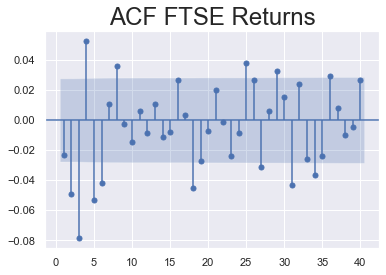

In [268]:
sgt.plot_acf(df.returns, lags = 40, zero = False)
plt.title("ACF FTSE Returns", size = 24)
plt.show()

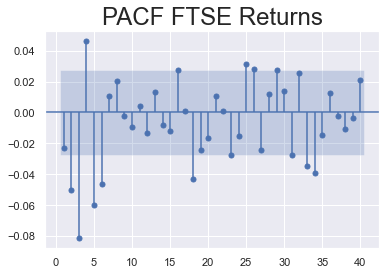

In [270]:
sgt.plot_pacf(df.returns, lags = 40, zero = False, method = ('ols'))
plt.title("PACF FTSE Returns", size = 24)
plt.show()

The results look similar to those we got for the ACF. 

One way to interpret this is the `prices today` often move in the `opposite direction of prices yesterday.` Hence, we tend to get price increases following price decreases, which falls in line with our expectation of cyclical changes.

Intuition dictates that the `further back we go, the less relevant the coefficient values should be.` That's because the `majority of effects they have on current values should already be accounted for due to the recursive nature of auto regressive models.`

### Interpretation of the PACF graph
#### 5 of the first 6 coefficients are significant and 4 of them are negative which suggests the market is trying to adjust.

### method()

Specifies which method for the calculations to use:

    “ywm” or “ywmle” : Yule-Walker without adjustment. Default.

    “yw” or “ywadjusted” : Yule-Walker with sample-size adjustment in denominator for acovf. Default.

    “ols” : regression of time series on lags of it and on constant.

    “ols-inefficient” : regression of time series on lags using a single common sample to estimate all pacf coefficients.

    “ols-adjusted” : regression of time series on lags with a bias adjustment.

    “ld” or “ldadjusted” : Levinson-Durbin recursion with bias correction.

    “ldb” or “ldbiased” : Levinson-Durbin recursion without bias correction.

### AR(1) for Returns

In [272]:
model_ret_ar_1 = ARMA(df.returns, order = (1, 0))

In [273]:
results_ret_ar_1 = model_ret_ar_1.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.57963D+00    |proj g|=  2.53575D-05

At iterate    5    f=  1.57963D+00    |proj g|=  2.22045D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      5      7      1     0     0   2.220D-08   1.580D+00
  F =   1.5796312195188147     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


In [275]:
results_ret_ar_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(1, 0)   Log Likelihood               -7929.749
Method:                       css-mle   S.D. of innovations              1.174
Date:                Tue, 18 Jan 2022   AIC                          15865.497
Time:                        22:30:33   BIC                          15885.061
Sample:                    01-10-1994   HQIC                         15872.353
                         - 04-05-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0188      0.016      1.159      0.247      -0.013       0.051
ar.L1.returns    -0.0230      0.014     -1.631      0.103      -0.051       0.005
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1          -43.4387           +0.0000j           43.4387            0.5000
-----------------------------------------------------------------------------
"""

P > 0.05 -> This means that `neither is significantly different from zero.` So this model holds `no real predictive power.` This can be explained by the impact past values can have on yesterday's prices. The more easily yesterday's price is affected by higher lags, the more inaccurate it's coefficient becomes. This is because of the accumulated compounding effects of lagged coefficients. This directly decreases the predictive power of the model. Therefore, we should proceed by testing whether a higher lag model serves as a better predictor.

### Higher-Lag AR Models for Returns

In [276]:
model_ret_ar_2 = ARMA(df.returns, order = (2, 0))

In [277]:
results_ret_ar_2 = model_ret_ar_2.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.57838D+00    |proj g|=  1.43929D-04

At iterate    5    f=  1.57838D+00    |proj g|=  4.44089D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      5      7      1     0     0   4.441D-08   1.578D+00
  F =   1.5783776316401592     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


In [278]:
results_ret_ar_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(2, 0)   Log Likelihood               -7923.456
Method:                       css-mle   S.D. of innovations              1.173
Date:                Tue, 18 Jan 2022   AIC                          15854.911
Time:                        22:41:05   BIC                          15880.996
Sample:                    01-10-1994   HQIC                         15864.052
                         - 04-05-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0188      0.015      1.220      0.222      -0.011       0.049
ar.L1.returns    -0.0242      0.014     -1.716      0.086      -0.052       0.003
ar.L2.returns    -0.0500      0.014     -3.550      0.000      -0.078      -0.022
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.2417           -4.4635j            4.4701           -0.2586
AR.2           -0.2417           +4.4635j            4.4701            0.2586
-----------------------------------------------------------------------------
"""

#### P value for ar.L2.returns = 0.00 => `PHI 2 is significantly different from zero` and `should be included in the model.`

#### Also, ` P value for ar.L1.returns in AR(2) < P value for ar.L1.returns in AR(1)`

##### NOTE - Since the p value for the new coefficient is zero, we suspect that the change in log likelihood is also significant.

In [279]:
LLR_test(model_ret_ar_1, model_ret_ar_2)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.57963D+00    |proj g|=  2.53575D-05

At iterate    5    f=  1.57963D+00    |proj g|=  2.22045D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      5      7      1     0     0   2.220D-08   1.580D+00
  F =   1.5796312195188147     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           12

At X0         0 v

 This problem is unconstrained.
 This problem is unconstrained.


0.0

##### NOTE - We get a p value of less than one percent, which supports the claim that this model is a better fit than the previous one i.e. `AR(2) > AR(1)`

##### Also, we can notice that all three indices or information criterion are lower than they were for the AR(1) model.

In [280]:
model_ret_ar_3 = ARMA(df.returns, order = (3, 0))

In [282]:
results_ret_ar_3 = model_ret_ar_3.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.57505D+00    |proj g|=  3.41727D-04

At iterate    5    f=  1.57505D+00    |proj g|=  3.33067D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      7      9      1     0     0   2.220D-08   1.575D+00
  F =   1.5750474909889789     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


In [283]:
results_ret_ar_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(3, 0)   Log Likelihood               -7906.738
Method:                       css-mle   S.D. of innovations              1.169
Date:                Tue, 18 Jan 2022   AIC                          15823.477
Time:                        22:56:49   BIC                          15856.083
Sample:                    01-10-1994   HQIC                         15834.902
                         - 04-05-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.014      1.330      0.184      -0.009       0.047
ar.L1.returns    -0.0283      0.014     -2.011      0.044      -0.056      -0.001
ar.L2.returns    -0.0521      0.014     -3.705      0.000      -0.080      -0.025
ar.L3.returns    -0.0815      0.014     -5.792      0.000      -0.109      -0.054
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.9233           -2.0210j            2.2219           -0.1818
AR.2            0.9233           +2.0210j            2.2219            0.1818
AR.3           -2.4855           -0.0000j            2.4855           -0.5000
-----------------------------------------------------------------------------
"""

In [284]:
LLR_test(model_ret_ar_2, model_ret_ar_3)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.57838D+00    |proj g|=  1.43929D-04

At iterate    5    f=  1.57838D+00    |proj g|=  4.44089D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      5      7      1     0     0   4.441D-08   1.578D+00
  F =   1.5783776316401592     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           12

At X0         0 v

 This problem is unconstrained.
 This problem is unconstrained.


0.0

Since the P value for the newest lag is zero. Yet again, we expect the LLR test to suggest that this model is better than the previous one i.e. `AR(3) > AR(2)`

As expected, we get zero, so the two log likelihoods are `distinctly different.`

##### NOTE -  Information criteria are lower once again, so we can safely assume this model outperforms its simpler counterpart.

### Important
We continue this process of jumping to higher lag AR models until we get the following:
1. The additional coefficient is insignificant.
2. The LLR test fails.
3. Higher AIC or BIC values.

<img src = "Images/LLR.png">

In [313]:
model_ret_ar_6 = ARMA(df.returns, order = (6, 0))
results_ret_ar_6 = model_ret_ar_6.fit()
results_ret_ar_6.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.57110D+00    |proj g|=  2.27818D-04

At iterate    5    f=  1.57110D+00    |proj g|=  6.66134D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7      6      8      1     0     0   4.441D-08   1.571D+00
  F =   1.5711045418931224     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(6, 0)   Log Likelihood               -7886.945
Method:                       css-mle   S.D. of innovations              1.164
Date:                Wed, 19 Jan 2022   AIC                          15789.890
Time:                        00:52:31   BIC                          15842.059
Sample:                    01-10-1994   HQIC                         15808.170
                         - 04-05-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.013      1.414      0.157      -0.007       0.045
ar.L1.returns    -0.0245      0.014     -1.740      0.082      -0.052       0.003
ar.L2.returns    -0.0523      0.014     -3.716      0.000      -0.080      -0.025
ar.L3.returns    -0.0870      0.014     -6.174      0.000      -0.115      -0.059
ar.L4.returns     0.0424      0.014      3.009      0.003       0.015       0.070
ar.L5.returns    -0.0607      0.014     -4.309      0.000      -0.088      -0.033
ar.L6.returns    -0.0466      0.014     -3.302      0.001      -0.074      -0.019
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.2869           -0.9022j            1.5716           -0.0973
AR.2            1.2869           +0.9022j            1.5716            0.0973
AR.3           -0.0727           -1.5282j            1.5299           -0.2576
AR.4           -0.0727           +1.5282j            1.5299            0.2576
AR.5           -1.8659           -0.4836j            1.9275           -0.4596
AR.6           -1.8659           +0.4836j            1.9275            0.4596
-----------------------------------------------------------------------------
"""

In [296]:
model_ret_ar_7 = ARMA(df.returns, order = (7, 0))
results_ret_ar_7 = model_ret_ar_7.fit()
results_ret_ar_7.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.57105D+00    |proj g|=  1.24412D-04

At iterate    5    f=  1.57105D+00    |proj g|=  3.55271D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8      7      9      1     0     0   4.441D-08   1.571D+00
  F =   1.5710452270886179     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(7, 0)   Log Likelihood               -7886.647
Method:                       css-mle   S.D. of innovations              1.164
Date:                Wed, 19 Jan 2022   AIC                          15791.294
Time:                        00:36:14   BIC                          15849.985
Sample:                    01-10-1994   HQIC                         15811.860
                         - 04-05-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.014      1.399      0.162      -0.008       0.045
ar.L1.returns    -0.0240      0.014     -1.702      0.089      -0.052       0.004
ar.L2.returns    -0.0517      0.014     -3.663      0.000      -0.079      -0.024
ar.L3.returns    -0.0874      0.014     -6.202      0.000      -0.115      -0.060
ar.L4.returns     0.0433      0.014      3.064      0.002       0.016       0.071
ar.L5.returns    -0.0601      0.014     -4.263      0.000      -0.088      -0.032
ar.L6.returns    -0.0463      0.014     -3.282      0.001      -0.074      -0.019
ar.L7.returns     0.0109      0.014      0.772      0.440      -0.017       0.039
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.6490           -0.5384j            1.7347           -0.4498
AR.2           -1.6490           +0.5384j            1.7347            0.4498
AR.3           -0.1189           -1.4954j            1.5001           -0.2626
AR.4           -0.1189           +1.4954j            1.5001            0.2626
AR.5            1.2790           -0.9786j            1.6105           -0.1039
AR.6            1.2790           +0.9786j            1.6105            0.1039
AR.7            5.2269           -0.0000j            5.2269           -0.0000
-----------------------------------------------------------------------------
"""

In [315]:
LLR_test(model_ret_ar_6, model_ret_ar_7)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.57110D+00    |proj g|=  2.27818D-04

At iterate    5    f=  1.57110D+00    |proj g|=  6.66134D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7      6      8      1     0     0   4.441D-08   1.571D+00
  F =   1.5711045418931224     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 v

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.57105D+00    |proj g|=  3.55271D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8      7      9      1     0     0   4.441D-08   1.571D+00
  F =   1.5710452270886179     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


0.44

### Normalizing Values
It is common to visualize time series data by graphing values over time. However, you may run into the following issues:

1. The resolution of your data does not match the resolution you want for your visualization.

##### For example, you want to plot a single value per minute, but your data is spaced in 10-second intervals. You will need to resample the data.

2. Your data is non-continuous, but you want to visualize a continuous time series.

##### For example, you want to plot every minute for the past 24 hours, but you are missing data for some intervals. You will need to fill in the missing values.

We prefer relying on `returns rather than prices` when using AR models. This is because of the non-stationary nature of prices.

Normalization can mean several different things. But in the case of TIME series, when we normalize a set of values, we basically `map every value of the sample space to the percentage of the first value of the set.` The resulting series is much easier to compare with other time series in general. 

By normalizing two time series, we can compare how well they perform relative to one another. This gives us a better understanding of which ones to invest in and which ones to avoid.

In [285]:
benchmark = df.market_value.iloc[0]

In [286]:
df['norm'] = df.market_value.div(benchmark).mul(100)

In [287]:
sts.adfuller(df.norm)

(-1.892871013267234,
 0.33542220743300766,
 6,
 5013,
 {'1%': -3.431655136974821,
  '5%': -2.8621167297421373,
  '10%': -2.567076993884522},
 19553.90073102193)

##### NOTE - As was the case with non normalized prices, we can see that the test yields a high p value, which suggests non stationary. Thus, normalizing prices did not result in stationary data. Therefore, we will not be able to use an AR model with the normalized prices. However, normalization is still a great practice for comparing Time series.

In [289]:
bench_ret = df.returns.iloc[0]
df['norm_ret'] = df.returns.div(bench_ret).mul(100)
sts.adfuller(df.norm_ret)

(-12.770265719497285,
 7.798058336036482e-24,
 32,
 4987,
 {'1%': -3.431661944885779,
  '5%': -2.8621197374408225,
  '10%': -2.5670785949998973},
 80114.49116124898)

##### NOTE - As was the case with non-normalized returns, the test statistic is significantly smaller than the one percent critical value of -3.431. Therefore, we can say with great certainty that this data is stationary. Furthermore, we can conclude that `normalizing does not affect stationarity.`

### Normalized Returns

In [290]:
model_norm_ret_ar_1 = ARMA(df.norm_ret, order = (1,0))
results_norm_ret_ar_1 = model_norm_ret_ar_1.fit()
results_norm_ret_ar_1.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.03820D+00    |proj g|=  2.30926D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      2      7      1     0     0   0.000D+00   8.038D+00
  F =   8.0381958792106580     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:               norm_ret   No. Observations:                 5020
Model:                     ARMA(1, 0)   Log Likelihood              -40351.743
Method:                       css-mle   S.D. of innovations            749.388
Date:                Wed, 19 Jan 2022   AIC                          80709.487
Time:                        00:11:03   BIC                          80729.050
Sample:                    01-10-1994   HQIC                         80716.342
                         - 04-05-2013                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const            -11.9731     10.339     -1.158      0.247     -32.237       8.291
ar.L1.norm_ret    -0.0230      0.014     -1.631      0.103      -0.051       0.005
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1          -43.4387           +0.0000j           43.4387            0.5000
-----------------------------------------------------------------------------
"""

##### NOTE - The P values are both greater than 0.1, so we can't be conclusively certain they are non-zero.

In [291]:
model_norm_ret_ar_2 = ARMA(df.norm_ret, order = (2,0))
results_norm_ret_ar_2 = model_norm_ret_ar_2.fit()
results_norm_ret_ar_2.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.03694D+00    |proj g|=  1.22569D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      3      5      1     0     0   1.776D-07   8.037D+00
  F =   8.0369422920408731     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:               norm_ret   No. Observations:                 5020
Model:                     ARMA(2, 0)   Log Likelihood              -40345.450
Method:                       css-mle   S.D. of innovations            748.449
Date:                Wed, 19 Jan 2022   AIC                          80698.901
Time:                        00:12:47   BIC                          80724.985
Sample:                    01-10-1994   HQIC                         80708.041
                         - 04-05-2013                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const            -11.9731      9.834     -1.218      0.223     -31.247       7.301
ar.L1.norm_ret    -0.0242      0.014     -1.716      0.086      -0.052       0.003
ar.L2.norm_ret    -0.0500      0.014     -3.550      0.000      -0.078      -0.022
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.2417           -4.4635j            4.4701           -0.2586
AR.2           -0.2417           +4.4635j            4.4701            0.2586
-----------------------------------------------------------------------------
"""

#### NOTE - `Using normalized values has no impact on model selection.`

### Analysing Residuals
`.resid` -> The residuals of the model

In [297]:
df['res_price'] = results_ar_7.resid

In [298]:
df.res_price.mean()

0.6797380579966433

In [299]:
df.res_price.var()

3468.125774195566

##### NOTE - The mean is close to zero, which suggests that on average, our model performs well, but the high variance indicates the residuals are not concentrated around the mean of zero, but are all over the place. This is primarily because AR models perform poorly when predicting non stationarity data.

In [300]:
sts.adfuller(df.res_price)

(-70.817136704767,
 0.0,
 0,
 5019,
 {'1%': -3.4316535759402753,
  '5%': -2.8621160400844468,
  '10%': -2.567076626752987},
 54832.41965646904)

##### NOTE - We get a P-value = 0. This suggests stationarity, so the error terms fit our expectations so far.

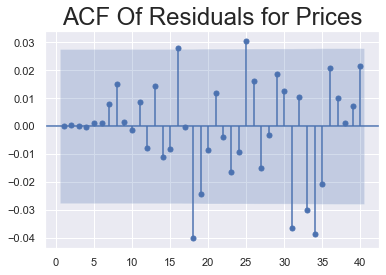

In [301]:
sgt.plot_acf(df.res_price, zero = False, lags = 40)
plt.title("ACF Of Residuals for Prices", size = 24)
plt.show()

After plotting the function, we can see that the majority of coefficients fall within the blue region which suggests they're `not significantly different from zero`, which fits the characteristics of `white noise`. However, the few points that fall outside this area lead us to believe that there's an `even better predictor.`

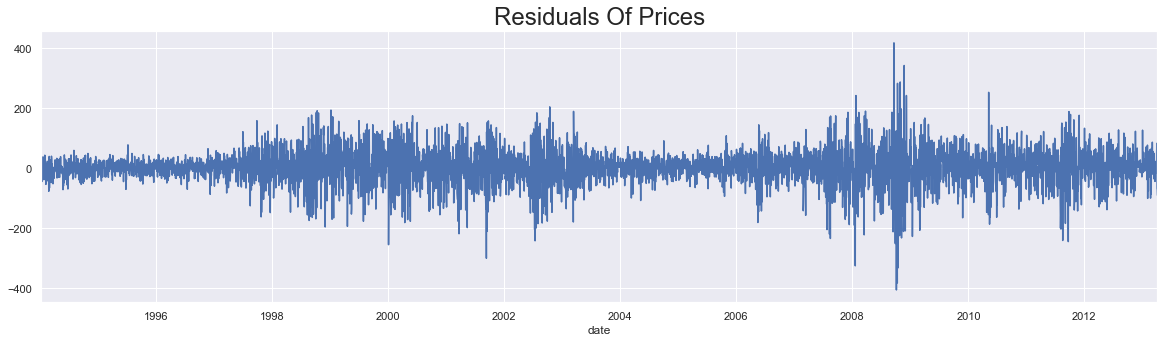

In [311]:
df.res_price.plot(figsize = (20,5))
plt.title("Residuals Of Prices", size = 24)
plt.show()

##### NOTE - We cannot find any obvious pattern for the data. So our choice of model seems correct. It's important to note that since we used an AR model on non-stationary data, our predictions might still be far from great.

In [316]:
df['res_ret'] = results_ret_ar_6.resid

In [317]:
df.res_ret.mean()

-5.372777827547422e-05

In [318]:
df.res_ret.var()

1.355980211073056

##### NOTE -  Values are closer to what we might expect from white noise data. Mean is extremely close to zero and a variance of around one indicate that our choice of model was pretty good.

In [319]:
sts.adfuller(df.res_ret)

(-70.78380089919209,
 0.0,
 0,
 5019,
 {'1%': -3.4316535759402753,
  '5%': -2.8621160400844468,
  '10%': -2.567076626752987},
 15692.570834205788)

##### NOTE - Running the DF test returns values close to those of the price residuals, so we have confirmation that the data is stationary. Since, white noise is also stationary, this is exactly what we want.

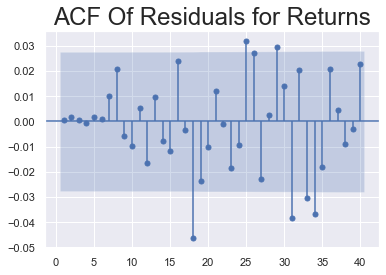

In [321]:
sgt.plot_acf(df.res_ret, zero = False, lags = 40)
plt.title("ACF Of Residuals for Returns", size = 24)
plt.show()

We can observe a very similar scenario where most but not all coefficients are not significant. Hence our model is a good predictor, but we have a good reason to believe a better one exists.

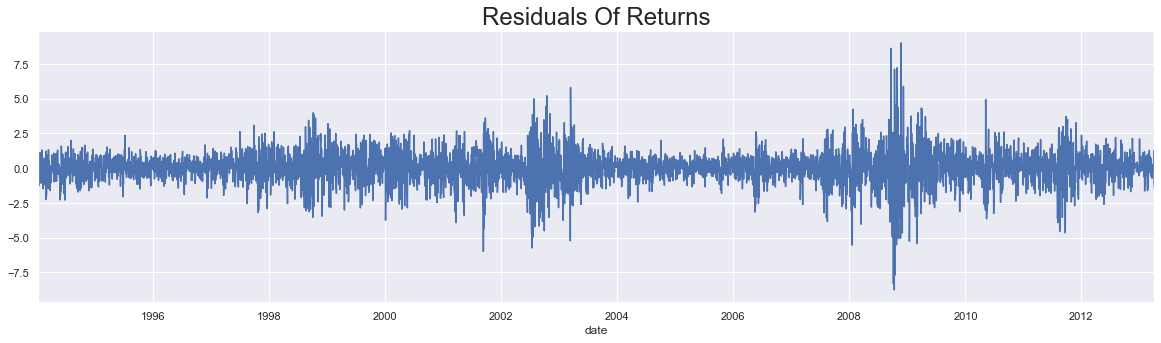

In [322]:
df.res_ret.plot(figsize = (20,5))
plt.title("Residuals Of Returns", size = 24)
plt.show()

### Box-Jenkins (BJ) Methodology
<img src = "Images/BJ.png">

### Identification
<img src = "Images/Bj1.jpeg">

<img src = "Images/steps.png">

### Estimation
<img src = "Images/estimation.png">
<img src = "Images/estimation1.png">
<img src = "Images/estimation2.png">

### Models Summary
<img src = "Images/model-summary.png">